## kNN Parameter Optimization

### Importing Packages

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Importing and Cleaning Data

In [23]:
sdata = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [24]:
sdata.shape

(5110, 12)

#### Adding Indicator Variables

In [25]:
sdata = sdata[sdata.gender != 'Other']
sdata['gender'] = sdata['gender'].replace({'Male':0,'Female':1}).astype(np.uint8)
sdata['ever_married'] =sdata['ever_married'].replace({'No':0,'Yes':1}).astype(np.uint8)
sdata['Residence_type'] =sdata['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)

In [26]:
one_hot = pd.get_dummies(sdata['work_type'])
sdata = sdata.drop('work_type',axis = 1)
sdata = sdata.join(one_hot)
one_hot = pd.get_dummies(sdata['smoking_status'])
sdata = sdata.drop('smoking_status',axis = 1)
sdata = sdata.join(one_hot)

In [27]:
null_data = sdata[sdata.isnull().any(axis=1)]
null_data['stroke'].sum()

40

### NaN Imputation using kNN

In [29]:
import math
math.sqrt(len(sdata))

70.05711955254797

In [30]:
# Drop NaN and reset index
sdata = sdata.dropna().reset_index()
# Create copy
sdata_imp = sdata.copy()

# Initiate datframe to record results
kNN_results = pd.DataFrame(columns = ['k value',
                                      'Relative Absolute Error'])

# Randomly select some samples from the bmi column and drop them
random_drops = sdata_imp['bmi'].sample(200, random_state=425)

# Loop over values of k
for k in range(1,100):
    
    # Drop 
    for drop in random_drops.index:
        sdata_imp['bmi'][drop] = np.NaN
    
    # Impute the NaN with different values of k
    imputer = KNNImputer(n_neighbors=k)
    sdata_imp = imputer.fit_transform(sdata_imp)
    sdata_imp = pd.DataFrame(sdata_imp, columns=sdata.columns)
    
    # Calulate total error for k
    total_error = 0
    for index in random_drops.index:
        error = abs(sdata['bmi'][index] - sdata_imp['bmi'][index])
        total_error = total_error + error
        
    # Caluclating relative error
    relative_error = total_error/ len(random_drops)
    
    # Append to datframe
    kNN_results = kNN_results.append({'k value':k, 
                                      'Relative Absolute Error': relative_error}, 
                                     ignore_index = True)

In [32]:
kNN_results.loc[kNN_results['Relative Absolute Error'].idxmin()]

k value                    91.000000
Relative Absolute Error     6.421984
Name: 90, dtype: float64

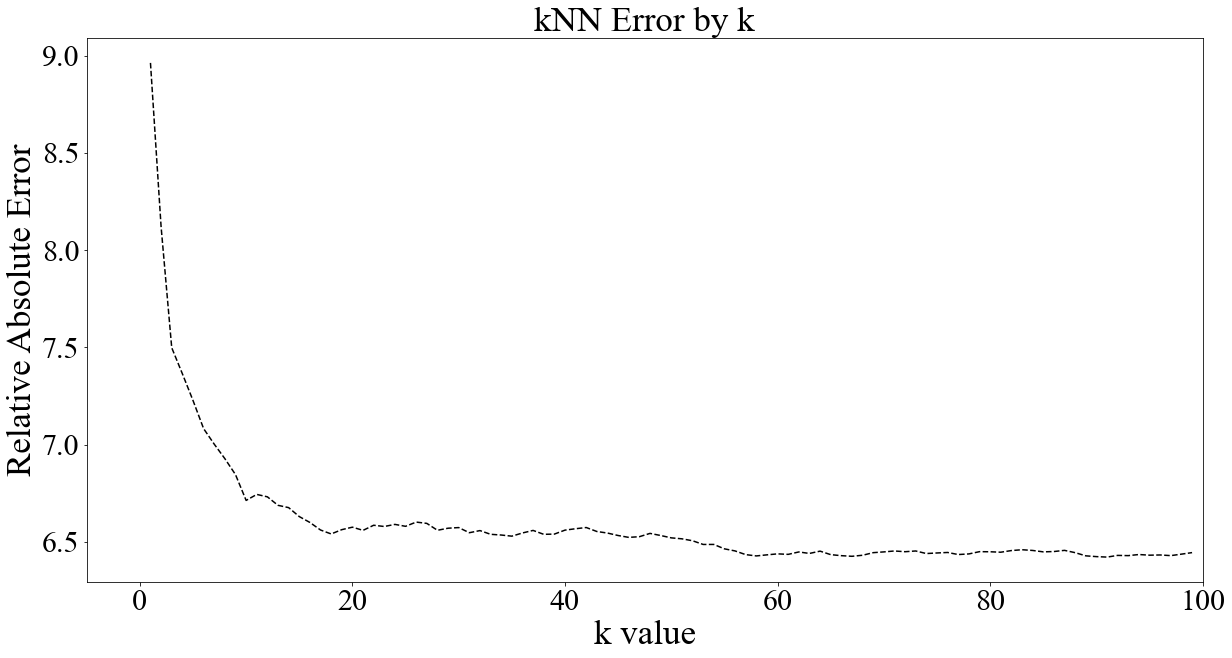

In [34]:
plt.rc('font',family='Times New Roman')
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(kNN_results['k value'], kNN_results['Relative Absolute Error'], 
         color='black', label='Error', linestyle='--')
plt.ylabel('Relative Absolute Error', fontsize=35)
plt.xlabel("k value", fontsize=35)
plt.title("kNN Error by k", fontsize=35)
plt.xlim((-5,100))
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#ax.axhline(y=kNN_results.loc[70]['Relative Absolute Error'], color="grey")
plt.show();

In [43]:
kNN_results.loc[70]['Relative Absolute Error']

1290.1746478873233

In [44]:
kNN_results.head(10)

,k value,Relative Absolute Error
0,1.0,1777.200000
1,2.0,1558.350000
2,3.0,1492.800000
3,4.0,1447.225000
4,5.0,1433.940000
5,6.0,1403.200000
6,7.0,1386.185714
7,8.0,1387.512500
8,9.0,1372.511111
9,10.0,1367.940000


### Miscellaneous Charts

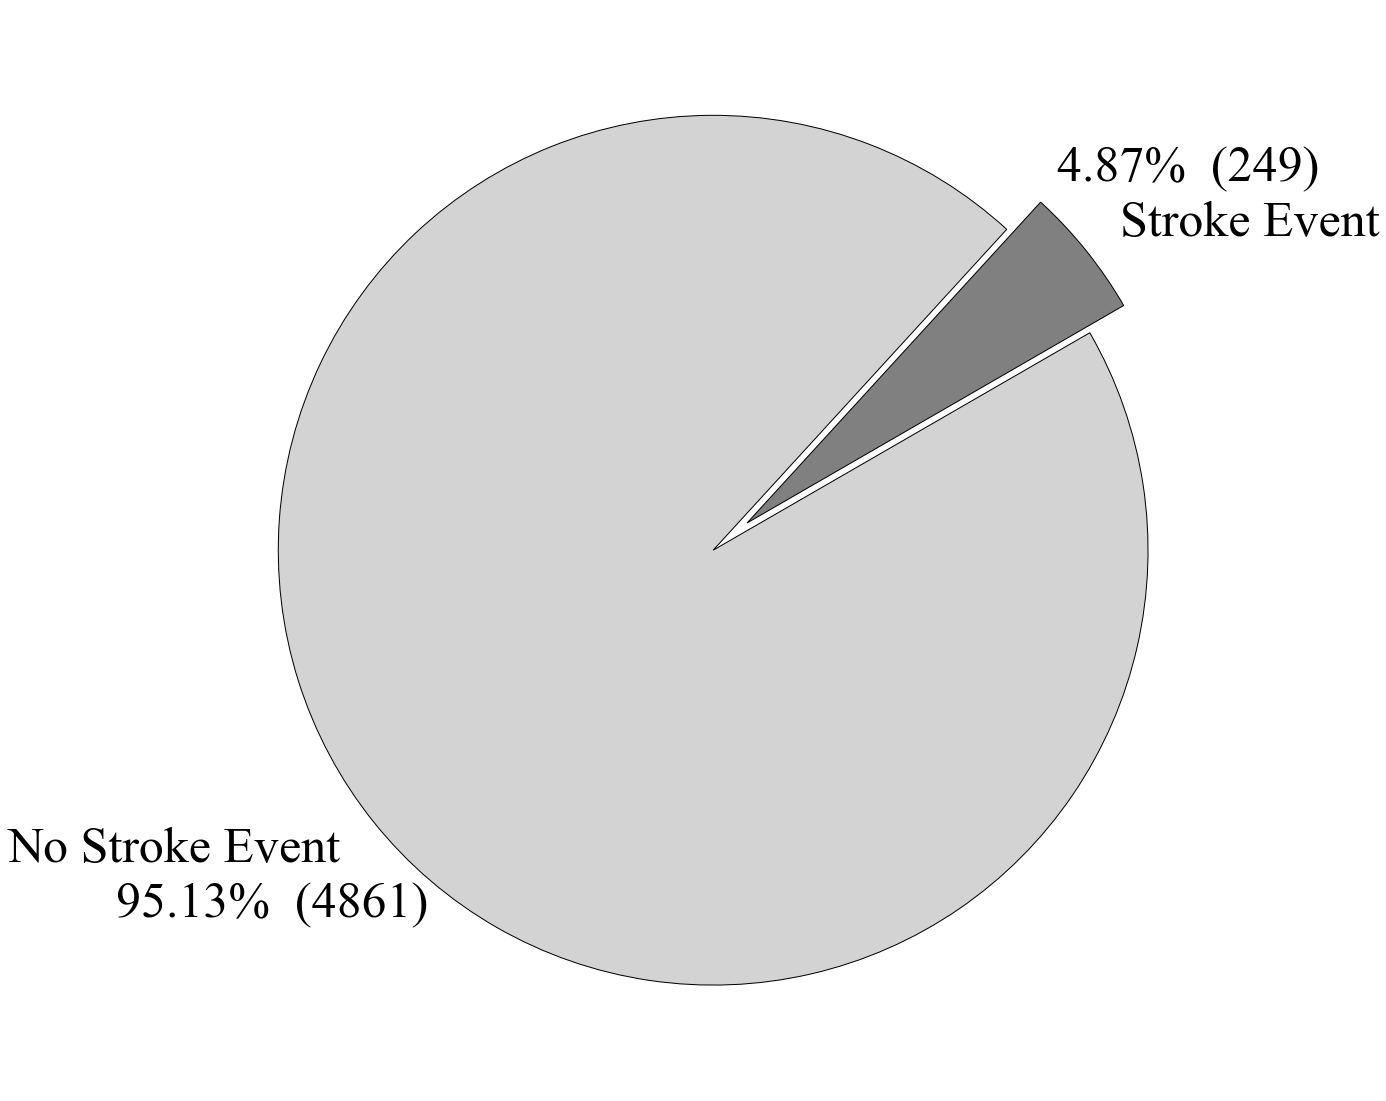

In [45]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 50
plt.rc('font',family='Times New Roman')


plt.figure(figsize=(20,20))
values = [249, 4861] 
labels = ['Stroke Event', 'No Stroke Event'] 
explode = [0.1,0]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(values, labels=labels, explode=explode, pctdistance=1.3, labeldistance=1.1, startangle=30,
        colors=("grey", "lightgrey"), autopct=make_autopct(values), 
       wedgeprops={"edgecolor":"k",'linewidth': 1})

plt.show();